In [1]:
import matplotlib.pyplot as plt 
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import seaborn as sns 
sns.set_style("whitegrid")
import copy

import numpy as np
# One true random seed
np.random.seed(42)

# Sklearn 
import sklearn as skl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# sipy
import scipy as spy
import scipy.signal as sig

# Noise Less Data 

Create a noise less sine wave and sample some data points from it

Text(0.5, 1.0, 'Noiseless Signal')

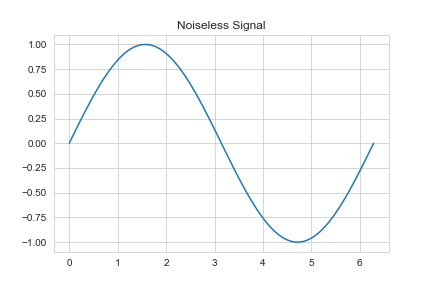

In [2]:
X = np.linspace(0, 2, 100)*np.pi
Y = np.sin(X)
Y = Y.reshape(-1,1)
X = X.reshape(-1,1)
plt.plot(X, Y)
plt.title("Noiseless Signal")

In [3]:
# Kernel
kernel = 1.0 * RBF(length_scale=1.00, length_scale_bounds=(1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1.0).fit(X, Y)

In [4]:
y_mean, y_cov = gp.predict(X.reshape(-1,1), return_cov=True)

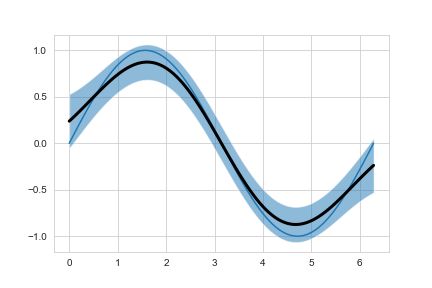

In [5]:
plt.plot(X, y_mean, 'k', lw=3, zorder=9)
y_lo = y_mean - np.sqrt(np.diag(y_cov)).reshape(-1,1)
y_hi = y_mean + np.sqrt(np.diag(y_cov)).reshape(-1,1)
plt.fill_between(X.reshape(100,), y_lo.reshape(100,), y_hi.reshape(100,), alpha=0.5)
plt.plot(X, Y)

# Thougts on noise
Sigma should be set based on the variation in the samples. 

## Numpy implementation 

In [6]:
# Squared Exponential kernel 
def kernel(x1, x2):
    d = spy.spatial.distance.cdist(x1, x2, 'euclidean')
    return np.exp(-0.5*d)

In [7]:
# Noise free prediction 
def predict_GP(X_post, X_prior, Y_prior, noise_var):
    X_post = X_post.reshape(-1,1)
    X_prior = X_prior.reshape(-1,1)
    Y_prior = Y_prior.reshape(-1,1)
    
    k_s = kernel(X_post, X_prior)
    k   = kernel(X_prior, X_prior)
    k_ss = kernel(X_post, X_post)
    
    var = np.linalg.inv(k + noise_var * np.eye(k.shape[0]))
    
    mean = k_s @ var @ Y_prior
    covar = k_ss - k_s @ var @ k_s.T
    return mean, covar 

In [8]:
X_po = np.linspace(0,2.0*np.pi,1000)
X_pr = np.linspace(0,2.0*np.pi,10)
Y_pr = np.sin(X_pr)

In [9]:
mean, cov = predict_GP(X_po, X_pr, Y_pr, 0.0010)

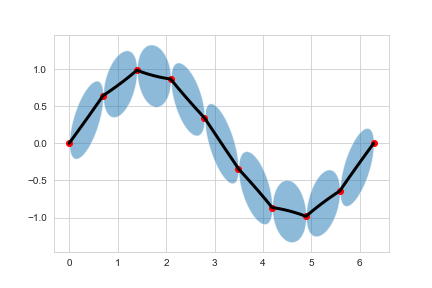

In [10]:
plt.plot(X_po, mean, 'k', lw=3, zorder=9)
y_lo = mean - np.sqrt(np.diag(cov)).reshape(-1,1)
y_hi = mean + np.sqrt(np.diag(cov)).reshape(-1,1)
plt.fill_between(X_po, y_lo.reshape(len(y_lo),), y_hi.reshape(len(y_hi),), alpha=0.5)
plt.plot(X_pr, Y_pr, "ro")

# Compare the performance with noise in the GP

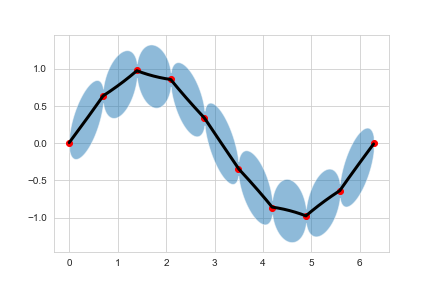

In [11]:
mean, cov = predict_GP(X_po, X_pr, Y_pr, 0.010)
plt.plot(X_po, mean, 'k', lw=3, zorder=9)
y_lo = mean - np.sqrt(np.diag(cov)).reshape(-1,1)
y_hi = mean + np.sqrt(np.diag(cov)).reshape(-1,1)
plt.fill_between(X_po, y_lo.reshape(len(y_lo),), y_hi.reshape(len(y_hi),), alpha=0.5)
plt.plot(X_pr, Y_pr, "ro")

So as we thought it just adds a band on the sampled point. 

# Thoughts on modelling uncertainity in storm water systems

There are two kinds of uncertanity that can impact the performance of the bayesian agent.
1. Rainfall Uncertanity 
2. Model Uncertanity

This uncertanity introduces randomness to the system which mainifests as the noise in the observations of the bayesian agent controlling the system.  

Consider the scenario where rainfall on the network is paramertrized by a random variables which is sampled from a gaussian distribition $\mathcal { N } \left( 0 , \sigma _ { r } ^ { 2 } \right)$ and storm water network whose parameters are also assumed to random and sampled from a gaussian   $\mathcal { N } \left( 0 , \sigma _ { m } ^ { 2 } \right)$.


When a agent attemps to take an action on a system whose response is charecterized by random variables, agent's oserved return would be random. 

$$ y_{observed} = f(\mathbf{X}) + \epsilon $$

The assumption on the randomness of the rainfall and the swmm parameters can probably be learnt by the agent as the epsilon.

In [12]:
def sample(ind):
    # Generate Noisy data
    base_signal = np.sin(np.linspace(0, 2.0, 100)*np.pi)
    # Make a distribution to sample from...
    noise = np.random.normal(0.0, 0.50, 1)
    # pick a point from the base signal 
    return base_signal[ind] + noise

In [13]:
X_sampled = np.zeros((100, 20))
Y_sampled = np.zeros_like(X_sampled)
a = np.linspace(0, 2.0, 100)*np.pi
for i in range(0, 100):
    for j in range(0, 20):
        Y_sampled[i, j] = sample(i)
        X_sampled[i, j] = a[i]

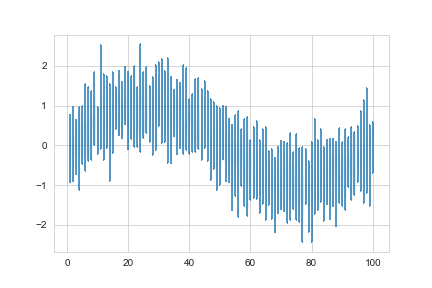

In [14]:
plt.violinplot(Y_sampled.T)
plt.show()

In [15]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [16]:
kernel_skl = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel_skl, n_restarts_optimizer=9)

In [17]:
X_train = X_sampled.ravel().reshape(-1,1)
Y_train = Y_sampled.ravel().reshape(-1,1)

In [18]:
gp.fit(X_train, Y_train)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-20376.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([43479.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [19]:
test = np.linspace(0, 2.0, 10)*np.pi
test = test.reshape(-1,1)
y_pred, sigma = gp.predict(test, return_std=True)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


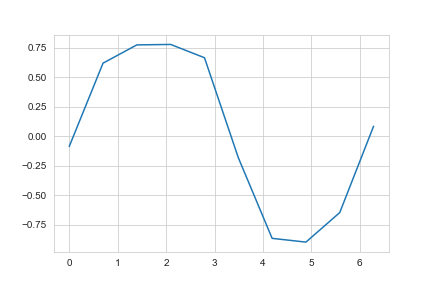

In [21]:
plt.plot(test, y_pred)

Using a simple RBF kernel for learning the noise seems to be useless. As far as I can tell the noise is being learnt as the distribution. May be if I sample a few points it might perform better.

In [35]:
def sample():
    # Generate Noisy data
    t= np.linspace(0, 2.0, 100)*np.pi
    base_signal = np.sin(t)
    # Make a distribution to sample from...
    noise = np.random.normal(0.0, 0.50, 1)
    # pick a point from the base signal 
    rand_point = np.random.choice(np.arange(0, 100, 1), 1)
    return base_signal[rand_point] + noise, t[rand_point]

samples = 1000
X_sampled = np.zeros((samples, 1))
Y_sampled = np.zeros_like(X_sampled)

for i in range(0, samples):
    Y_sampled[i, 0], X_sampled[i, 0] = sample()

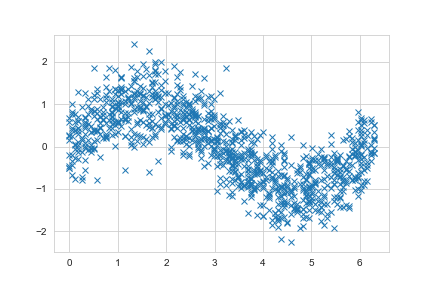

In [36]:
plt.plot(X_sampled, Y_sampled, 'x')

In [37]:
kernel_skl = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel_skl, n_restarts_optimizer=9)

In [38]:
X_train = X_sampled.ravel().reshape(-1,1)
Y_train = Y_sampled.ravel().reshape(-1,1)

In [39]:
gp.fit(X_train, Y_train)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1370.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [40]:
test = np.linspace(0, 2.0, 10)*np.pi
test = test.reshape(-1,1)
y_pred, sigma = gp.predict(test, return_std=True)

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


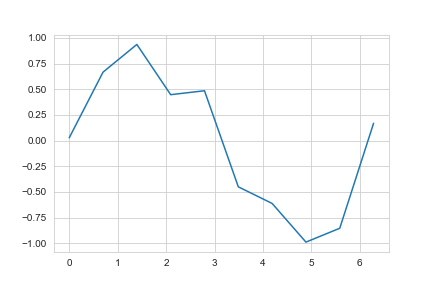

In [41]:
plt.plot(test, y_pred)

In [42]:
sigma

array([0.00000000e+00, 0.00000000e+00, 6.80696069e-06, 2.12837444e-03,
       0.00000000e+00, 0.00000000e+00, 3.09609054e-06, 5.50974339e-06,
       0.00000000e+00, 1.69145492e-03])

So any information on the noise is lost in the sampling.....

# gpytorch 

This has a rbf kernel with the length parameter and a white noise kernel. So hope is that noise can be modeled from this. 